<a href="https://colab.research.google.com/github/narenq7/Dive2DLPytorch/blob/main/Function_Approximators_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Useful External Resources

1. https://mlu-explain.github.io/
2. https://bergwald.github.io/neural-networks/

## Neural Networks in PyTorch

This tutorial provides a basic introduction to building and training neural networks using PyTorch.

These are a class of function approximators $f_\theta$, where $\theta$ parametrizes the $f$.

### 1. Introduction

Neural networks are a powerful class of machine learning models inspired by the structure and function of the human brain. They are composed of interconnected nodes (neurons) organized in layers, which process and transform input data to produce an output. PyTorch is a popular deep learning framework that provides tools for building and training neural networks.

- Weights $W_i \in \mathbb{R}^{m \times n}$
- Bias $b_i \in \mathbb{R}^m$
- Activation $g_i: \mathbb{R}^m \mapsto \mathbb{R}^m$
    - Sigmoid: $\sigma(x) = 1/(1 + e^{-x})$
    - Hyperbolic Tangent: $\tanh(x) = (e^{x} - e^{-x})/(e^{x} + e^{-x})$
    - Rectified Linear Unit: $ReLU(x) = \max(0, x)$

Hence, in a simple neural network, also commonly known as Multi-Layered Perceptron (MLP), we will have the "learnable parameters" $\theta$ as all $W$'s and $b$'s. More complex architectures like Convolutional NNs or Recurrent NNs will include some other extra parameters.

Let us take an example below:

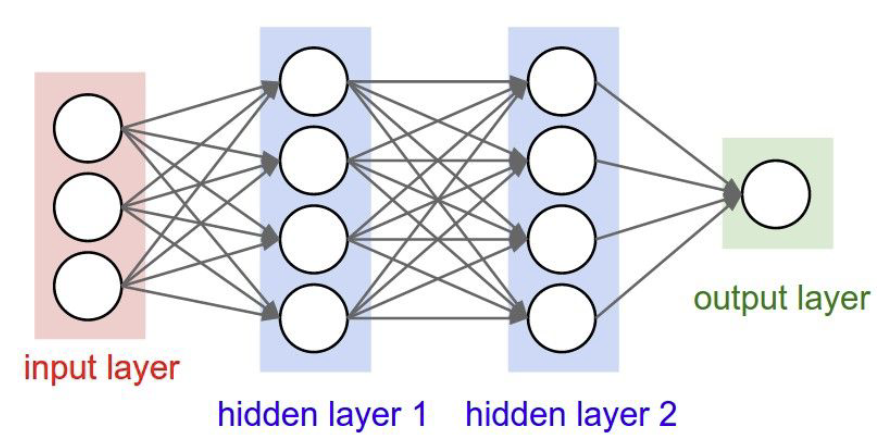

Here we have,
1. Input Layer as a vector $x$
2. Hidden Layer 1 which does the transformation $h_1 = g_1(W_1 x + b_1)$
3. Hidden Layer 2 which does the transformation $h_2 = g_1(W_2 h_1 + b_2)$
3. Output Layer doing the final transformation $y = g_y(W_y h_2 + b_y)$

So in the end the "neural network" is nothing but a series of function compositions parametrized by $\theta$ which we optimize

### 2. Generate Problem Dataset

As an example, we will try to learn a function approximator for a circle with noisy radius.

First lets generate some data:

Angles Shape:  (1000,)
X Shape:  (1000,)
Y Shape:  (1000,)


Text(0.5, 1.0, 'Noisy Circle Data')

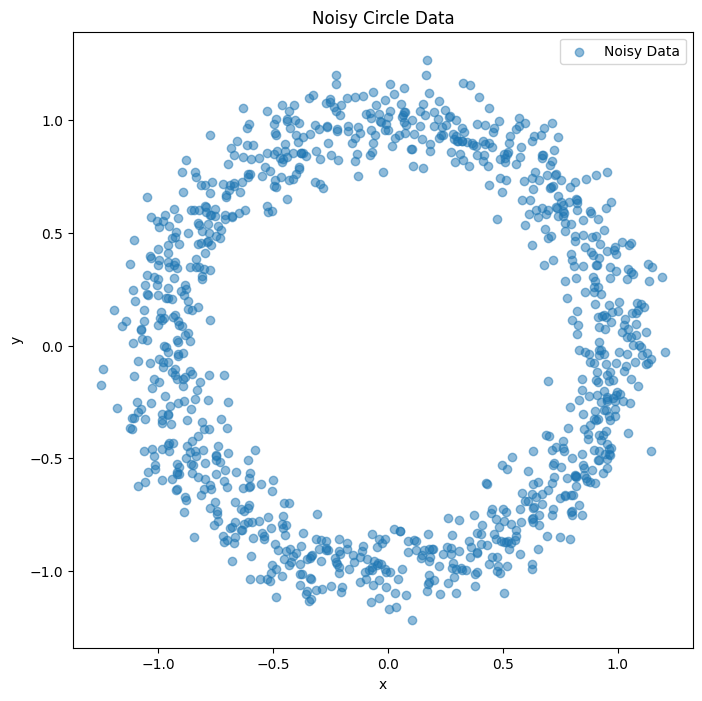

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Generate noisy circle data
def generate_circle_data(radius, num_points, noise_level):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = radius * np.cos(angles) + np.random.normal(0, noise_level, num_points)
    y = radius * np.sin(angles) + np.random.normal(0, noise_level, num_points)
    return angles, x, y

# Generate data
radius = 1.0
num_points = 1000
# [TRY]: 0.01, 0.5, 1.0
noise_level = 0.1
angles, x, y = generate_circle_data(radius, num_points, noise_level)
print('Angles Shape: ', angles.shape)
print('X Shape: ', x.shape)
print('Y Shape: ', y.shape)

# Prepare data for PyTorch
angles_tensor = torch.tensor(angles, dtype=torch.float32).view(-1, 1)
coordinates_tensor = torch.tensor(np.vstack((x, y)).T, dtype=torch.float32)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, label='Noisy Data', alpha=0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy Circle Data')


### 3. Building a Neural Network

Let's start by building a simple neural network with three hidden layer using PyTorch:

In [ ]:
import torch
import torch.nn as nn


# Define the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # [TRY]: Change the activations to one of the following: nn.Tanh(), nn.Sigmoid()
        # [TRY]: Change the dimensions of hidden layer: 16, 512
        self.fc = nn.Sequential(
            nn.Linear(1, 2), # W x + b
            nn.Tanh(), # Activation
            nn.Linear(2, 4), # W x + b
            nn.Tanh(), # Activation
            nn.Linear(4, 2)  # Predict 2 quantities
            # Notice I didn't add any activation here, what would happen if I add sigmoid here? or relu?
        )

    def forward(self, x):
        return self.fc(x)

model = Model()
unlearnt_model = Model() # for comparison

**Explanation:**

- `nn.Module`: The base class for all neural network modules in PyTorch.
- `nn.Linear`: A linear layer that applies a linear transformation to the input.
- `F.relu`: The ReLU (Rectified Linear Unit) activation function, which introduces non-linearity.
- `Sequential`: Useful for writing all the operators in a list
- `forward`: Defines the forward pass of the network, specifying how the input is transformed to produce the output.

### 3. Training the Network

To find a "good" $\theta$ we have to solve the following optimization problem:
$$
\min_{{\theta}} \mathcal{L}({\theta}; \mathcal{D})
$$

$\mathcal{L}({\theta}; \mathcal{D})$ is the loss function, which measures the discrepancy between the predicted outputs and the true labels.

$\mathcal{D} = \{({x}_i, {y}_i)\}_{i=1}^N$ is the training dataset, consisting of $N$ input-output pairs.

\

For our example we will consider
$\mathcal{L}({\theta}; \mathcal{D}) = \frac{1}{N} \sum_{i=1}^N (f_\theta(x_i) - {y}_i)^2$



The optimization algorithm that we will use is Adaptive Moment Estimation (Adam).
Explaining this is out of scope for this workshop, hence for a better understanding please refer to the external resources.

In [ ]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.MSELoss()

# [TRY]: SGD, Adamax,
optimizer = optim.Adam(model.parameters(), lr=0.01)

**Explanation:**

- `nn.MSELoss`: A loss function commonly used for regression problems.
- `optim.Adam`: An optimization algorithm that updates the network's parameters to minimize the loss.

Now, we can train the network using a training loop:

Epoch [10/1000], Loss: 0.5232


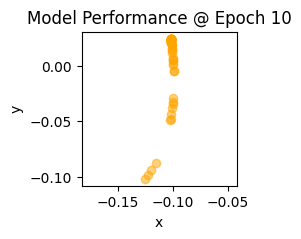

Epoch [50/1000], Loss: 0.4782


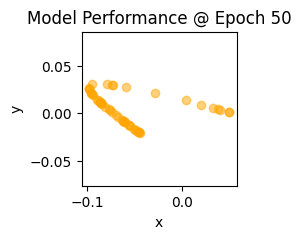

Epoch [200/1000], Loss: 0.0620


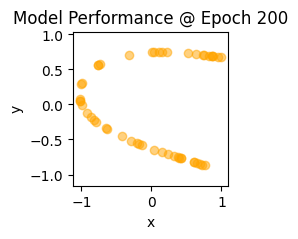

Epoch [800/1000], Loss: 0.0143


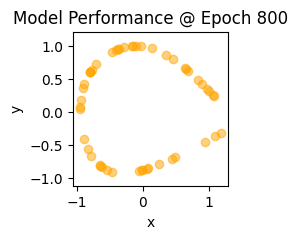

In [ ]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    outputs = model(angles_tensor)
    loss = criterion(outputs, coordinates_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) in [10, 50, 200, 800]:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        with torch.inference_mode():
            mb_batch_indx = np.random.randint(0, num_points, 50)
            predictions = model(angles_tensor[mb_batch_indx]).numpy()

            # Plot Performance
            plt.figure(figsize=(2, 2))
            plt.scatter(predictions[:, 0], predictions[:, 1], alpha=0.5, color='orange')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Model Performance @ Epoch {epoch + 1}')
            plt.axis('equal')
            plt.show()

**Explanation:**

- The training loop iterates over the training data in batches.
- For each batch, it performs a forward pass to compute the output, calculates the loss, and updates the network's parameters using backpropagation.

### 4. Evaluation

After training, we can evaluate the network's performance:

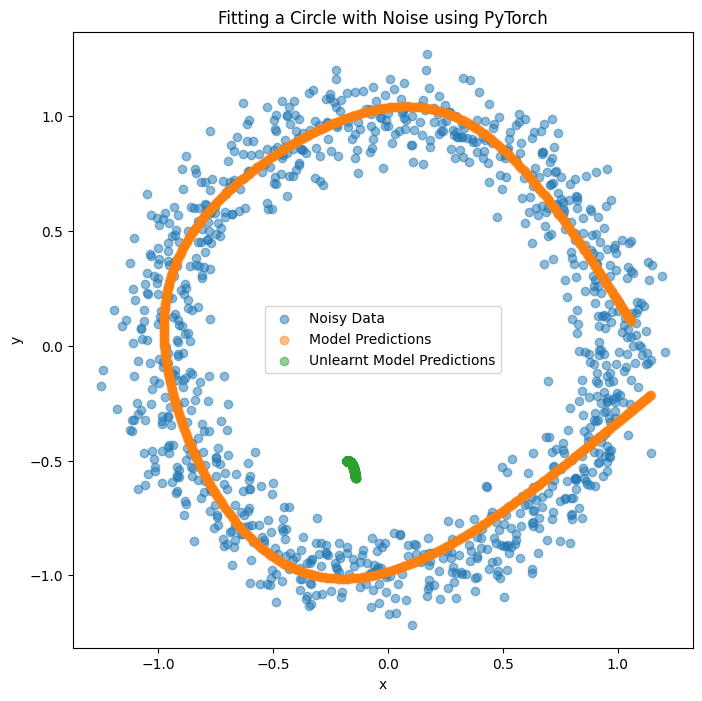

In [ ]:
model.eval()
unlearnt_model.eval()

with torch.inference_mode():
    predictions = model(angles_tensor).numpy()
    unlearnt_predictions = unlearnt_model(angles_tensor).numpy()

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(x, y, label='Noisy Data', alpha=0.5)
plt.scatter(predictions[:, 0], predictions[:, 1], label='Model Predictions', alpha=0.5)
plt.scatter(unlearnt_predictions[:, 0], unlearnt_predictions[:, 1], label='Unlearnt Model Predictions', alpha=0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitting a Circle with Noise using PyTorch')
plt.axis('equal')
plt.show()